<a href="https://colab.research.google.com/github/bmshahrier/bixi-montreal/blob/master/bixi_montreal_regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split

# sklearn :: models
from sklearn.ensemble import GradientBoostingRegressor

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')

#**Problem Defination:**

Apply regression model to predict BIXI Bike demand for each station


# **Load the Data**

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Explore the contents of GDrive
!ls -la /content/gdrive/My\ Drive/Colab\ Notebooks/bixi-montreal/processed-data

total 591036
-rw------- 1 root root  21085242 Jun  6 02:32 bixi-trip-weather-data-2018-04.csv
-rw------- 1 root root 584134502 Jun  8 01:27 bixi-trip-weather-data-2018.csv


In [24]:
# Load BIXI processes data of 2018
df_bixi = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/bixi-montreal/processed-data/bixi-trip-groupby-data-2018.csv', error_bad_lines=False)
df_bixi.head()

,Station Code,Month,Day,Week Day,Hour,Bike Departed,Bike Arrived,Temp (°C),Rel Hum (%),Wind Spd (km/h),Visibility (km)
0,6064,4,10,1,11,1,0,2.6,53.0,16.0,24.1
1,6100,4,10,1,11,0,1,2.6,53.0,16.0,24.1
2,6108,4,10,1,11,0,1,2.6,53.0,16.0,24.1
3,6114,4,10,1,11,1,0,2.6,53.0,16.0,24.1
4,6141,4,10,1,11,1,0,2.6,53.0,16.0,24.1


# **Feature Reengineering**

In [25]:
df_bixi.columns

Index(['Station Code', 'Month', 'Day', 'Week Day', 'Hour', 'Bike Departed',
       'Bike Arrived', 'Temp (°C)', 'Rel Hum (%)', 'Wind Spd (km/h)',
       'Visibility (km)'],
      dtype='object')

In [0]:
# Create new features from Month
col = 'Month'
df_dummies = pd.get_dummies(df_bixi[col])
df_dummies.columns = [str(col)+'_'+str(c) for c in df_dummies.columns]
df_bixi = pd.concat([df_bixi, df_dummies], axis=1)

In [0]:
# Create new features from Day
col = 'Day'
df_dummies = pd.get_dummies(df_bixi[col])
df_dummies.columns = [str(col)+'_'+str(c) for c in df_dummies.columns]
df_bixi = pd.concat([df_bixi, df_dummies], axis=1)

In [0]:
# Create new features from Week Day
col = 'Week Day'
df_dummies = pd.get_dummies(df_bixi[col])
df_dummies.columns = [str(col)+'_'+str(c) for c in df_dummies.columns]
df_bixi = pd.concat([df_bixi, df_dummies], axis=1)

In [0]:
# Create new features from Day
col = 'Hour'
df_dummies = pd.get_dummies(df_bixi[col])
df_dummies.columns = [str(col)+'_'+str(c) for c in df_dummies.columns]
df_bixi = pd.concat([df_bixi, df_dummies], axis=1)

count    1905271.0
mean          17.0
std            8.0
min          -11.0
25%           12.0
50%           19.0
75%           24.0
max           35.0
Name: Temp (°C), dtype: float64


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


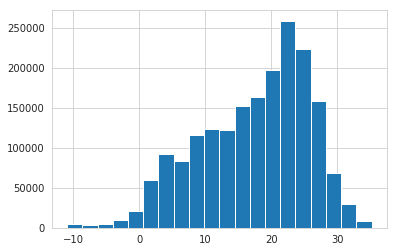

In [30]:
# Temparature distribution
# Histogram
print(df_bixi['Temp (°C)'].describe().round())
plt.hist(df_bixi['Temp (°C)'], bins=20)
plt.show()

In [34]:
# convert Tempatature into groups
def convert_temp_group(val):
    if val >=-12 and val < -10:
        return 'T:-12to-10'
    elif val >=-10 and val < -8:
        return 'T:-10to-8'
    elif val >=-8 and val < -6:
        return 'T:-8to-6'
    elif val >=-6 and val < -4:
        return 'T:-6to-4'
    elif val >=-4 and val < -2:
        return 'T:-4to-2'
    elif val >=-2 and val < 0:
        return 'T:-2to0'
    elif val >=0 and val < 2:
        return 'T:-0to2'
    elif val >=2 and val < 4:
        return 'T:2to4'
    elif val >=4 and val < 6:
        return 'T:4to6'
    elif val >=6 and val < 8:
        return 'T:6to8'
    elif val >=8 and val < 10:
        return 'T:8to10'
    elif val >=10 and val < 12:
        return 'T:10to12'
    elif val >=12 and val < 14:
        return 'T:12to14'
    elif val >=14 and val < 16:
        return 'T:14to16'
    elif val >=16 and val < 18:
        return 'T:16to18'
    elif val >=18 and val < 20:
        return 'T:18to20'
    elif val >=20 and val < 22:
        return 'T:20to22'
    elif val >=22 and val < 24:
        return 'T:22to24'
    elif val >=24 and val < 26:
        return 'T:24to26'
    elif val >=26 and val < 28:
        return 'T:26to28'
    elif val >=28 and val < 30:
        return 'T:28to30'
    elif val >=30 and val < 32:
        return 'T:30to32'
    elif val >=32 and val < 34:
        return 'T:32to34'
    elif val >=34 and val < 36:
        return 'T:34to36'
    else:
        return 'T:36+'
        
df_bixi['Temp (°C)'] = df_bixi['Temp (°C)'].apply(convert_temp_group)
print ('Unique Values in the Column:', np.unique(df_bixi['Temp (°C)']))

# Create new features from Temp (°C)
convert_temp = pd.get_dummies(df_bixi['Temp (°C)']).astype(int)
df_bixi = pd.concat([df_bixi, convert_temp], axis=1)

Unique Values in the Column: ['T:-0to2' 'T:-10to-8' 'T:-12to-10' 'T:-2to0' 'T:-4to-2' 'T:-6to-4'
 'T:-8to-6' 'T:10to12' 'T:12to14' 'T:14to16' 'T:16to18' 'T:18to20'
 'T:20to22' 'T:22to24' 'T:24to26' 'T:26to28' 'T:28to30' 'T:2to4'
 'T:30to32' 'T:32to34' 'T:34to36' 'T:36+' 'T:4to6' 'T:6to8' 'T:8to10']


# **Define Columns for Prediction**

In [35]:
# Dataframe columns
df_bixi.columns

Index(['Station Code', 'Month', 'Day', 'Week Day', 'Hour', 'Bike Departed',
       'Bike Arrived', 'Temp (°C)', 'Rel Hum (%)', 'Wind Spd (km/h)',
       ...
       'T:26to28', 'T:28to30', 'T:2to4', 'T:30to32', 'T:32to34', 'T:34to36',
       'T:36+', 'T:4to6', 'T:6to8', 'T:8to10'],
      dtype='object', length=106)

In [0]:
feature = list(df_bixi)

# items to be removed 
unwanted_feature = {'Station Code', 'Month', 'Day', 'Week Day', 'Hour', 'Bike Departed',
       'Bike Arrived', 'Temp (°C)', 'Rel Hum (%)', 'Wind Spd (km/h)',
       'Visibility (km)'}


list1 = [ele for ele in feature if ele not in unwanted_feature]

In [0]:
# select the columns
X_columns = list1
y_column = ['Bike Departed']

# **Model Training**

In [41]:
# split the data using sklearn

threshold = 0.8
X = df_bixi[X_columns]
y = df_bixi[y_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0-threshold, shuffle=True)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (1524838, 95)
y_train (1524838, 1)
X_test (381210, 95)
y_test (381210, 1)


In [42]:
# train a linear regression
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# **Model Evaluation**

MAE 2.15
RMSE 3.6647


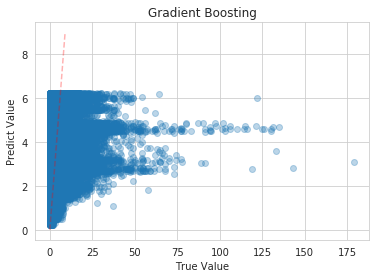

In [44]:
mae = mean_absolute_error(y_test, y_pred)
print('MAE', round(mae, 2))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE', round(rmse, 4))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot(range(0,10), range(0,10), '--r', alpha=0.3, label='Line1')
plt.title('Gradient Boosting')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.show()

# **Error Analysis**

In [45]:
#for i in range(len(X_test.columns)):
fi = []
for i, col in enumerate(X_test.columns):
    fi.append([col, model.feature_importances_[i]])
pd.DataFrame(fi).sort_values(1, ascending=False)

,0,1
63,Hour_17,2.015861e-01
54,Hour_8,8.176758e-02
62,Hour_16,7.920511e-02
64,Hour_18,7.356825e-02
7,Month_11,5.754438e-02
6,Month_10,5.486200e-02
0,Month_4,5.331605e-02
45,Week Day_6,4.565061e-02
52,Hour_6,3.678910e-02
44,Week Day_5,3.526277e-02


In [46]:
df_test = pd.DataFrame(X_test).copy()
df_test['Bike Departed'] = y_test
df_test['prediction'] = y_pred
df_test['abs_error'] = abs(df_test['Bike Departed']-df_test['prediction'])
df_test.sort_values(by='abs_error', ascending=False).round()

,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,Week Day_0,...,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,T:-0to2,T:-10to-8,T:-12to-10,T:-2to0,T:-4to-2,T:-6to-4,T:-8to-6,T:10to12,T:12to14,T:14to16,T:16to18,T:18to20,T:20to22,T:22to24,T:24to26,T:26to28,T:28to30,T:2to4,T:30to32,T:32to34,T:34to36,T:36+,T:4to6,T:6to8,T:8to10,Bike Departed,prediction,abs_error
525888,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,179,3.0,176.0
802949,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,143,3.0,140.0
1448231,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,135,5.0,130.0
791943,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,133,4.0,129.0
999198,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,131,5.0,126.0
586007,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,130,5.0,125.0
1399458,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,130,5.0,125.0
1334754,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,126,5.0,121.0
213837,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,125,5.0,120.0
1344388,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,121,5.0,116.0
